In [44]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [46]:
cur_folder_name = os.getcwd().split('/')[-1]
if cur_folder_name != "fairness-variance":
    os.chdir("../..")

print('Current location: ', os.getcwd())

Current location:  c:\


# Visualizations

In [47]:
import os
import pandas as pd

from virny.utils.custom_initializers import create_models_metrics_dct_from_database_df

from source.utils.db_functions import read_model_metric_dfs_from_db
from source.custom_classes.experiments_composer import ExperimentsComposer
from source.custom_classes.experiments_visualizer import ExperimentsVisualizer

from virny.utils.custom_initializers import create_models_metrics_dct_from_database_df

from source.visualizations import preprocess_metrics, create_group_base_and_fair_models_box_plot, \
    create_scatter_plot, create_group_models_box_plot_per_test_set, create_bar_plot_for_model_selection

## Initialize Configs

In [48]:
#DB_COLLECTION_NAME = 'bootstrap_sizes_experiment'
DB_COLLECTION_NAME = 'eq_odds_postprocessing_new'
DATASET_NAME = 'ACSIncome'

EXPERIMENTS_SESSION_UUID = {
    "0.8": "6c1ea468-8164-4e68-9ca2-129bc5e23424",
    "0.5": "f4cfb252-9282-4590-af0d-eb9fdc8e2e09",
    "0.2": "094a4224-8bb1-4499-9d63-88cbdcff9cf7"
}

SENSITIVE_ATTRS = ['SEX', 'RAC1P', 'SEX&RAC1P']
MODEL_NAMES = ['RandomForestClassifier']

In [49]:
from source.utils.db_functions import connect_to_mongodb

client, collection_obj, db_writer_func = connect_to_mongodb(DB_COLLECTION_NAME)

## Group Metrics Composition

### Boostrap_size = 0.8

In [50]:
model_metric_dfs = read_model_metric_dfs_from_db(collection_obj, EXPERIMENTS_SESSION_UUID["0.2"])
models_metrics_dct = create_models_metrics_dct_from_database_df(model_metric_dfs)
client.close()

In [51]:
for model_name in models_metrics_dct.keys():
    models_metrics_dct[model_name]['Test_Set_Index'] = 0

In [52]:
df = models_metrics_dct[list(models_metrics_dct.keys())[0]]
df[(df.Metric == 'Label_Stability')].T

,60,61,62,63,64,65,66,67,68,69
Metric,Label_Stability,Label_Stability,Label_Stability,Label_Stability,Label_Stability,Label_Stability,Label_Stability,Label_Stability,Label_Stability,Label_Stability
Model_Name,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier
Model_Params,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
Dataset_Name,Folktables_GA_2018_Income,Folktables_GA_2018_Income,Folktables_GA_2018_Income,Folktables_GA_2018_Income,Folktables_GA_2018_Income,Folktables_GA_2018_Income,Folktables_GA_2018_Income,Folktables_GA_2018_Income,Folktables_GA_2018_Income,Folktables_GA_2018_Income
Num_Estimators,200,200,200,200,200,200,200,200,200,200
Tag,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK
Record_Create_Date_Time,2023-12-06 22:46:39.980000,2023-12-06 22:52:34.778000,2023-12-06 22:47:00.323000,2023-12-06 22:53:23.771000,2023-12-06 22:45:59.206000,2023-12-06 22:52:09.033000,2023-12-06 22:46:07.922000,2023-12-06 22:52:28.927000,2023-12-06 22:42:06.712000,2023-12-06 22:48:35.873000
Session_Uuid,094a4224-8bb1-4499-9d63-88cbdcff9cf7,094a4224-8bb1-4499-9d63-88cbdcff9cf7,094a4224-8bb1-4499-9d63-88cbdcff9cf7,094a4224-8bb1-4499-9d63-88cbdcff9cf7,094a4224-8bb1-4499-9d63-88cbdcff9cf7,094a4224-8bb1-4499-9d63-88cbdcff9cf7,094a4224-8bb1-4499-9d63-88cbdcff9cf7,094a4224-8bb1-4499-9d63-88cbdcff9cf7,094a4224-8bb1-4499-9d63-88cbdcff9cf7,094a4224-8bb1-4499-9d63-88cbdcff9cf7
Experiment_Iteration,Exp_iter_1,Exp_iter_1,Exp_iter_2,Exp_iter_2,Exp_iter_3,Exp_iter_3,Exp_iter_4,Exp_iter_4,Exp_iter_5,Exp_iter_5
Dataset_Split_Seed,100,100,200,200,300,300,400,400,500,500


In [53]:
exp_composer = ExperimentsComposer(models_metrics_dct, SENSITIVE_ATTRS)
exp_subgroup_metrics_dct = exp_composer.create_exp_subgroup_metrics_dct_for_mult_test_sets()

In [54]:
exp_group_metrics_dct = exp_composer.compose_group_metrics_for_mult_test_sets(exp_subgroup_metrics_dct)

In [55]:
melted_all_subgroup_metrics_per_model_dct, melted_all_group_metrics_per_model_dct = \
    preprocess_metrics(exp_subgroup_metrics_dct, exp_group_metrics_dct)

In [56]:
test_df = melted_all_subgroup_metrics_per_model_dct["RandomForestClassifier"]
test_df[(test_df['Metric'] == 'Label_Stability') & (test_df["Subgroup"] == 'overall')][["Experiment_Iteration", "Intervention_Param", "Metric", "Metric_Value"]].sort_values(["Intervention_Param", "Experiment_Iteration"])

,Experiment_Iteration,Intervention_Param,Metric,Metric_Value
331,Exp_iter_1,0.0,Label_Stability,0.865707
331,Exp_iter_2,0.0,Label_Stability,0.866927
331,Exp_iter_3,0.0,Label_Stability,0.869660
331,Exp_iter_4,0.0,Label_Stability,0.881047
331,Exp_iter_5,0.0,Label_Stability,0.872700
221,Exp_iter_1,1.0,Label_Stability,0.839407
221,Exp_iter_2,1.0,Label_Stability,0.836713
221,Exp_iter_3,1.0,Label_Stability,0.842340
221,Exp_iter_4,1.0,Label_Stability,0.851960
221,Exp_iter_5,1.0,Label_Stability,0.845927


In [57]:
melted_all_subgroup_metrics_per_model_dct['RandomForestClassifier']["Intervention_Param"]= melted_all_subgroup_metrics_per_model_dct['RandomForestClassifier']["Intervention_Param"].astype(bool)

<Figure size 1200x600 with 0 Axes>

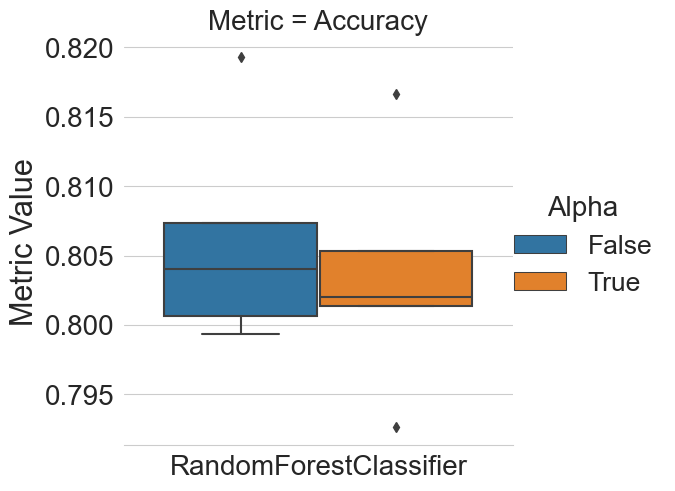

In [58]:
create_group_base_and_fair_models_box_plot(melted_all_subgroup_metrics_per_model_dct,
                                           #ylim=(0.8, 0.84),
                                           metric_names=['Accuracy'],
                                           )

<Figure size 1200x600 with 0 Axes>

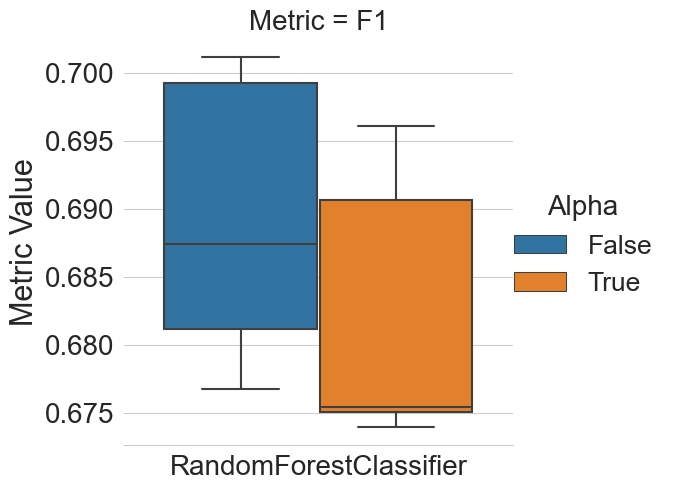

In [59]:
create_group_base_and_fair_models_box_plot(melted_all_subgroup_metrics_per_model_dct,
                                           #ylim=(0.7, 0.710),
                                           metric_names=['F1'],
                                           )

<Figure size 1200x600 with 0 Axes>

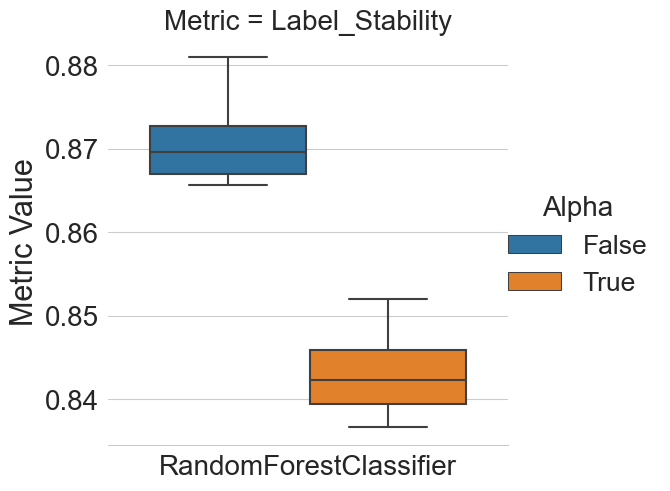

In [60]:
create_group_base_and_fair_models_box_plot(melted_all_subgroup_metrics_per_model_dct,
                                           #ylim=(0.925, 1.005),
                                           metric_names=['Label_Stability'])

<Figure size 1200x600 with 0 Axes>

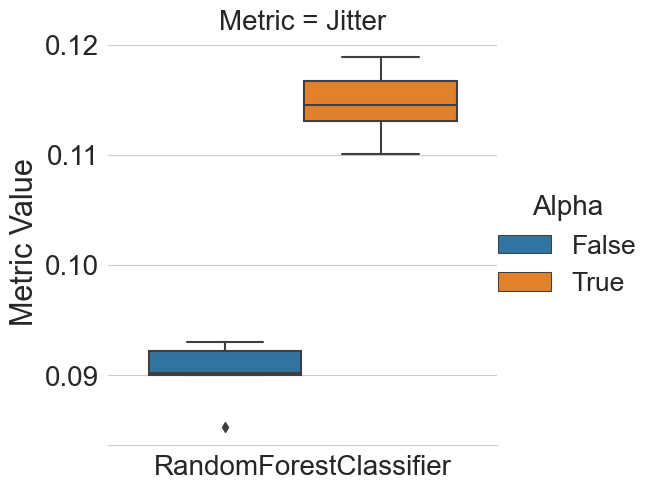

In [61]:
create_group_base_and_fair_models_box_plot(melted_all_subgroup_metrics_per_model_dct,
                                           #ylim=(0.925, 1.005),
                                           metric_names=['Jitter'])

<Figure size 1200x600 with 0 Axes>

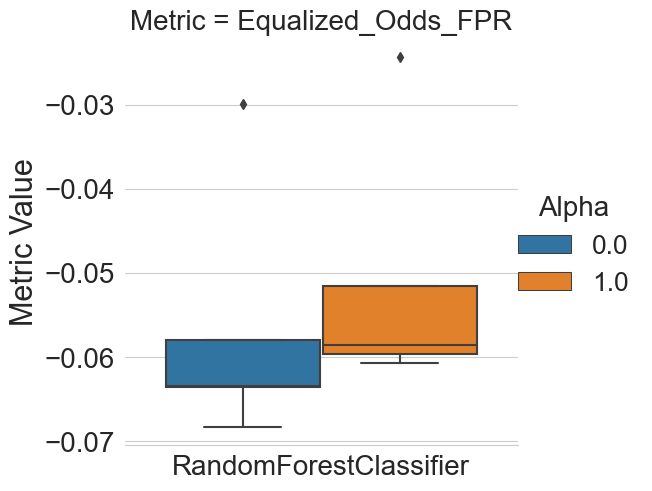

In [62]:
create_group_base_and_fair_models_box_plot(melted_all_group_metrics_per_model_dct,
                                           group='RAC1P',
                                           metric_names=['Equalized_Odds_FPR'])

<Figure size 1200x600 with 0 Axes>

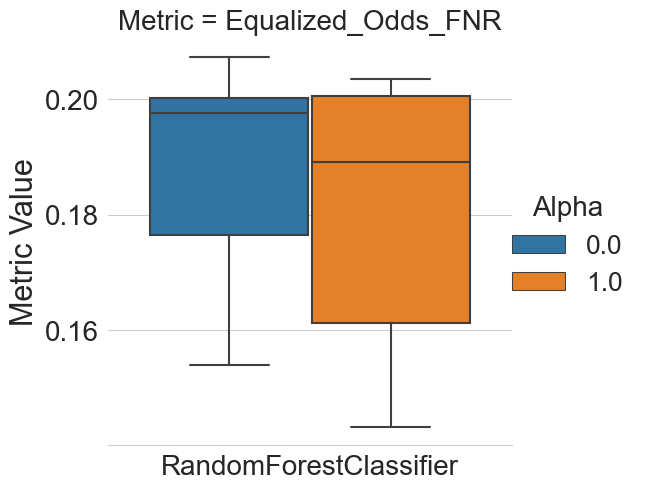

In [63]:
create_group_base_and_fair_models_box_plot(melted_all_group_metrics_per_model_dct,
                                           group='RAC1P',
                                           metric_names=['Equalized_Odds_FNR'])